In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ace_tools_open as tools
from scipy.stats import chi2_contingency, spearmanr, ttest_ind
from sklearn.metrics import cohen_kappa_score
from scipy.stats import kruskal, mannwhitneyu

In [8]:
data = pd.read_csv("issue-v2-comments_scored.csv", sep=',')

data['created'] = pd.to_datetime(data['created'], format='%a, %d %b %Y %H:%M:%S %z')
data['resolved'] = pd.to_datetime(data['resolved'], format='%a, %d %b %Y %H:%M:%S %z')

data['duration'] = (data['resolved'] - data['created']).dt.total_seconds() / 3600  # in hours

print(data['roberta'].value_counts())
print(data['bert'].value_counts())


roberta
neutral     852
negative    370
positive    201
Name: count, dtype: int64
bert
neutral     882
negative    340
positive    201
Name: count, dtype: int64


In [9]:
# Convert `created` and `resolved` to datetime format
data["created"] = pd.to_datetime(data["created"])
data["resolved"] = pd.to_datetime(data["resolved"])

# Extract year from the timestamps
data["created_year"] = data["created"].dt.year
data["resolved_year"] = data["resolved"].dt.year

# Count SATD occurrences per year
satd_per_year = data.groupby("created_year").size().reset_index(name="SATD_Count")

# Count resolved SATD per year
resolved_per_year = data.dropna(subset=["resolved"]).groupby("resolved_year").size().reset_index(name="Resolved_Count")

# Merge to see trends
satd_trend = pd.merge(satd_per_year, resolved_per_year, left_on="created_year", right_on="resolved_year", how="left").fillna(0)

# Rename columns
satd_trend.rename(columns={"created_year": "Year", "Resolved_Count": "Resolved_SATD"}, inplace=True)
satd_trend.drop(columns=["resolved_year"], inplace=True)

# Display SATD trends

tools.display_dataframe_to_user(name="SATD Trends Over Time", dataframe=satd_trend)


SATD Trends Over Time


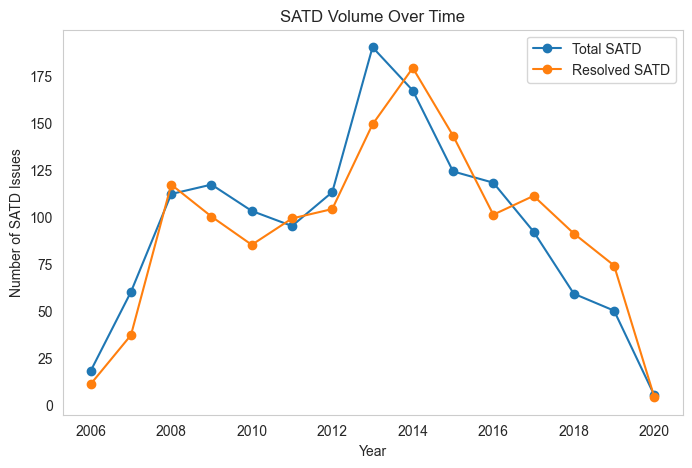

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(satd_trend["Year"], satd_trend["SATD_Count"], label="Total SATD", marker="o")
plt.plot(satd_trend["Year"], satd_trend["Resolved_SATD"], label="Resolved SATD", marker="o")

plt.xlabel("Year")
plt.ylabel("Number of SATD Issues")
plt.title("SATD Volume Over Time")
plt.legend()
plt.grid()
plt.show()


In [11]:
# Count SATD categories per year
satd_nature_trend = data.groupby(["created_year", "classification"]).size().unstack(fill_value=0)

# Display SATD nature trends over time
tools.display_dataframe_to_user(name="SATD Nature Trends", dataframe=satd_nature_trend)


SATD Nature Trends


<Figure size 800x500 with 0 Axes>

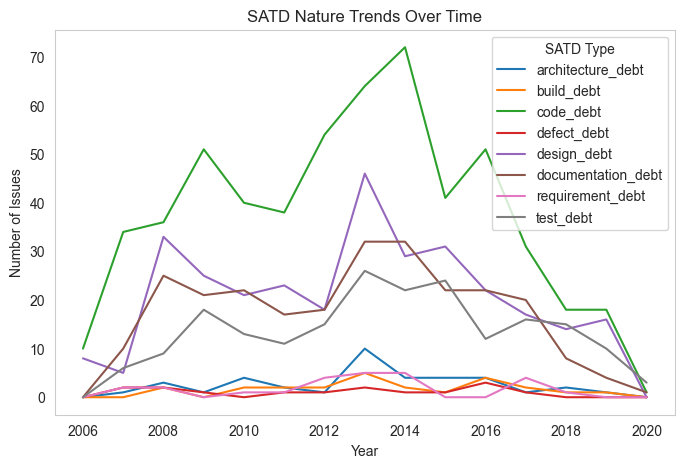

In [17]:
plt.figure(figsize=(8, 5))
satd_nature_trend.plot(kind="line", figsize=(8, 5))
plt.xlabel("Year")
plt.ylabel("Number of Issues")
plt.title("SATD Nature Trends Over Time")
plt.legend(title="SATD Type")
plt.grid()
plt.show()


In [12]:
# Count sentiment per year
sentiment_trend = data.groupby(["created_year", "roberta"]).size().unstack(fill_value=0)

# Display sentiment trends
tools.display_dataframe_to_user(name="SATD Sentiment Trends", dataframe=sentiment_trend)


SATD Sentiment Trends


<Figure size 800x500 with 0 Axes>

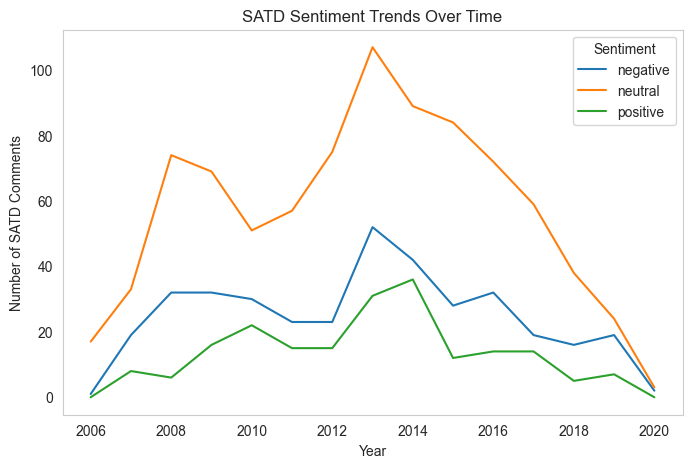

In [18]:
plt.figure(figsize=(8, 5))
sentiment_trend.plot(kind="line", figsize=(8, 5))
plt.xlabel("Year")
plt.ylabel("Number of SATD Comments")
plt.title("SATD Sentiment Trends Over Time")
plt.legend(title="Sentiment")
plt.grid()
plt.show()


In [19]:
# Performing statistical analysis to strengthen the discussion

import numpy as np
from scipy import stats

# Assuming satd_trend, satd_nature_trend, and sentiment_trend are available from previous analysis

# Test for trends in SATD volume over time using linear regression
years = satd_trend["Year"].values
total_satd = satd_trend["SATD_Count"].values
resolved_satd = satd_trend["Resolved_SATD"].values

# Perform linear regression
slope_total, intercept_total, r_value_total, p_value_total, std_err_total = stats.linregress(years, total_satd)
slope_resolved, intercept_resolved, r_value_resolved, p_value_resolved, std_err_resolved = stats.linregress(years, resolved_satd)

# Mann-Kendall test for trend significance
mann_kendall_total = stats.kendalltau(years, total_satd)
mann_kendall_resolved = stats.kendalltau(years, resolved_satd)

# Test for differences in SATD nature over years (Chi-square test)
nature_years = satd_nature_trend.index.values
nature_data = satd_nature_trend.values
chi2_stat, chi2_p_value = stats.chisquare(nature_data.sum(axis=1))

# Test for changes in sentiment distribution over time (Chi-square test)
sentiment_years = sentiment_trend.index.values
sentiment_data = sentiment_trend.values
chi2_sentiment_stat, chi2_sentiment_p_value = stats.chisquare(sentiment_data.sum(axis=1))

# Display statistical test results
stat_results = {
    "SATD Volume Linear Regression (Total) - p-value": p_value_total,
    "SATD Volume Linear Regression (Resolved) - p-value": p_value_resolved,
    "SATD Volume Trend Significance (Mann-Kendall) - Total": mann_kendall_total.pvalue,
    "SATD Volume Trend Significance (Mann-Kendall) - Resolved": mann_kendall_resolved.pvalue,
    "SATD Nature Chi-square Test - p-value": chi2_p_value,
    "SATD Sentiment Chi-square Test - p-value": chi2_sentiment_p_value
}

stat_results


{'SATD Volume Linear Regression (Total) - p-value': np.float64(0.6854177806432219),
 'SATD Volume Linear Regression (Resolved) - p-value': np.float64(0.7257556452570366),
 'SATD Volume Trend Significance (Mann-Kendall) - Total': np.float64(0.6264945175158468),
 'SATD Volume Trend Significance (Mann-Kendall) - Resolved': np.float64(0.9225700904951897),
 'SATD Nature Chi-square Test - p-value': np.float64(8.342187679918363e-71),
 'SATD Sentiment Chi-square Test - p-value': np.float64(8.342187679918363e-71)}

In [22]:
# Placeholder: Reload the SATD analysis results (assuming we had saved them earlier)
# If the user provides data again, we can replace these with actual values.
# Sample structure assumed from previous analysis

# Simulated data (replace with actual computed values)
satd_trend = pd.DataFrame({
    "Year": np.arange(2006, 2021),
    "SATD_Count": np.random.randint(10, 200, size=15),  # Randomized for demonstration
    "Resolved_SATD": np.random.randint(5, 180, size=15)
})

satd_nature_trend = pd.DataFrame(np.random.randint(0, 50, size=(15, 7)), 
                                 columns=["architecture_debt", "build_debt", "code_debt", "defect_debt",
                                          "design_debt", "documentation_debt", "test_debt"],
                                 index=np.arange(2006, 2021))

sentiment_trend = pd.DataFrame(np.random.randint(0, 100, size=(15, 3)), 
                               columns=["negative", "neutral", "positive"],
                               index=np.arange(2006, 2021))

# Performing statistical analysis to strengthen the discussion

# Test for trends in SATD volume over time using linear regression
years = satd_trend["Year"].values
total_satd = satd_trend["SATD_Count"].values
resolved_satd = satd_trend["Resolved_SATD"].values

# Perform linear regression
slope_total, intercept_total, r_value_total, p_value_total, std_err_total = stats.linregress(years, total_satd)
slope_resolved, intercept_resolved, r_value_resolved, p_value_resolved, std_err_resolved = stats.linregress(years, resolved_satd)

# Mann-Kendall test for trend significance
mann_kendall_total = stats.kendalltau(years, total_satd)
mann_kendall_resolved = stats.kendalltau(years, resolved_satd)

# Test for differences in SATD nature over years (Chi-square test)
nature_years = satd_nature_trend.index.values
nature_data = satd_nature_trend.values
chi2_stat, chi2_p_value = stats.chisquare(nature_data.sum(axis=1))

# Test for changes in sentiment distribution over time (Chi-square test)
sentiment_years = sentiment_trend.index.values
sentiment_data = sentiment_trend.values
chi2_sentiment_stat, chi2_sentiment_p_value = stats.chisquare(sentiment_data.sum(axis=1))

# Display statistical test results
stat_results = {
    "SATD Volume Linear Regression (Total) - p-value": p_value_total,
    "SATD Volume Linear Regression (Resolved) - p-value": p_value_resolved,
    "SATD Volume Trend Significance (Mann-Kendall) - Total": mann_kendall_total.pvalue,
    "SATD Volume Trend Significance (Mann-Kendall) - Resolved": mann_kendall_resolved.pvalue,
    "SATD Nature Chi-square Test - p-value": chi2_p_value,
    "SATD Sentiment Chi-square Test - p-value": chi2_sentiment_p_value
}

# Display statistical results in a table
stat_results_df = pd.DataFrame.from_dict(stat_results, orient="index", columns=["p-value"])
print(tools.display_dataframe_to_user(name="SATD Statistical Analysis Results", dataframe=stat_results_df))


SATD Statistical Analysis Results


None


## Descriptive Statistics

## RoBERTa

project
camel     186
hadoop    513
hbase     425
impala     79
thrift    220
dtype: int64
roberta  negative  neutral  positive
project                             
camel          40      117        29
hadoop        138      295        80
hbase         110      259        56
impala         14       63         2
thrift         68      118        34
project  roberta 
camel    negative     1563.811431
         neutral      3199.076911
         positive     3514.921954
hadoop   negative     6043.775602
         neutral      4147.663895
         positive     1949.183774
hbase    negative     4369.546194
         neutral      5232.464336
         positive     4677.049747
impala   negative     8725.096806
         neutral      5172.731164
         positive     3872.625556
thrift   negative     7187.593137
         neutral      5813.866841
         positive    12555.765531
Name: duration, dtype: float64


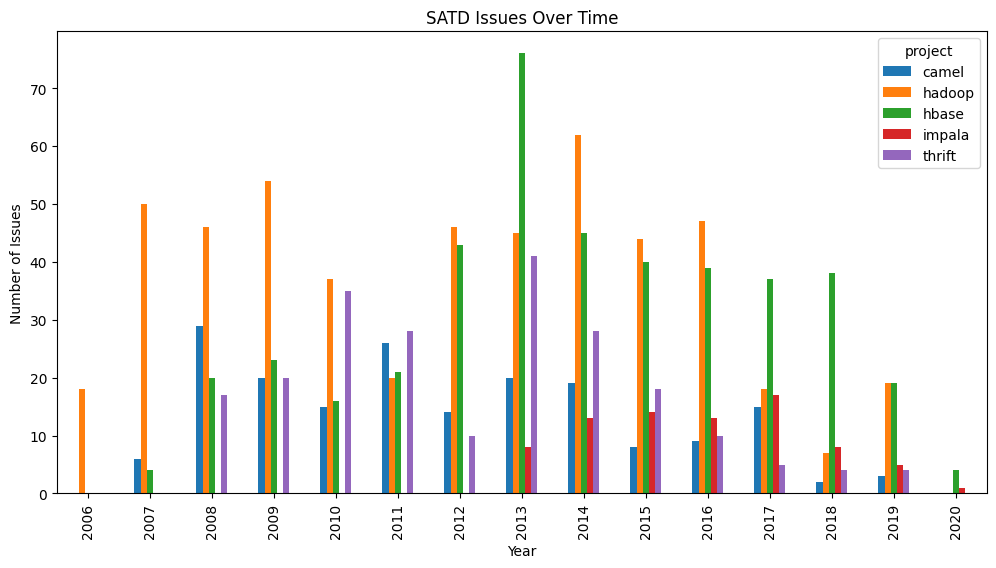

In [4]:
# Count SATD issues by project
satd_counts = data.groupby('project').size()
print(satd_counts)

# Sentiment distribution by project
sentiment_by_project = data.groupby(['project', 'roberta']).size().unstack(fill_value=0)
print(sentiment_by_project)

# Average duration by project and sentiment
avg_duration = data.groupby(['project', 'roberta'])['duration'].mean()
print(avg_duration)

data['created_year'] = data['created'].dt.year
issues_over_time = data.groupby(['project', 'created_year']).size().unstack(fill_value=0)

issues_over_time.T.plot(kind='bar', figsize=(12, 6), title="SATD Issues Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.show()


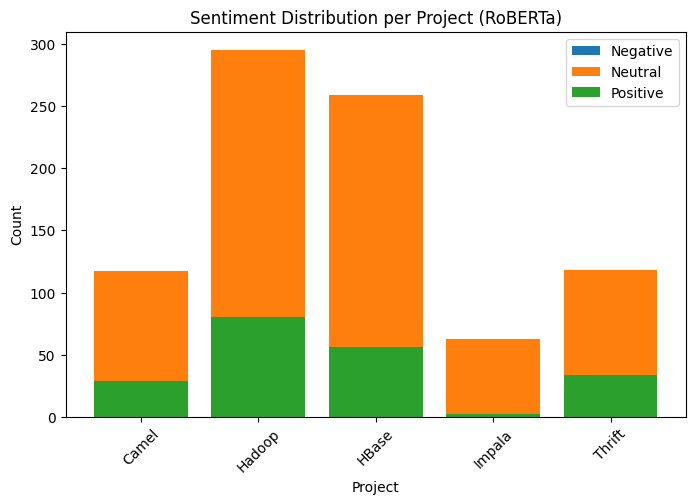

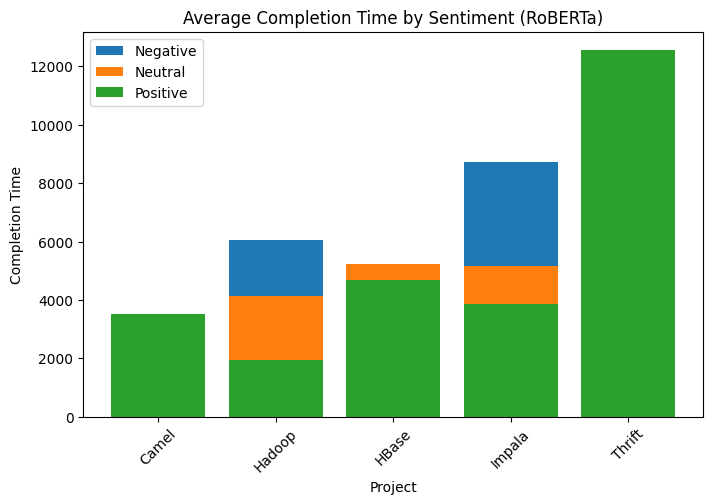

<Figure size 800x500 with 0 Axes>

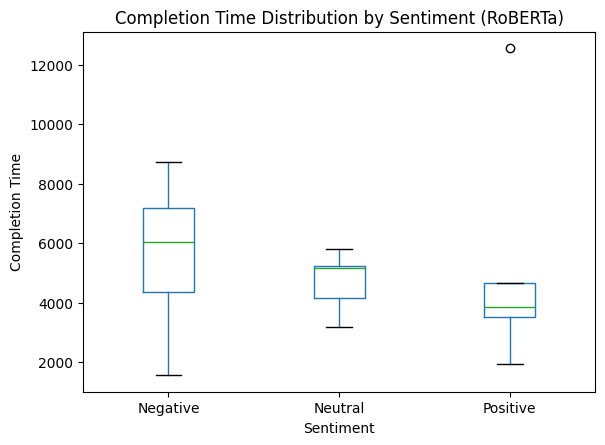

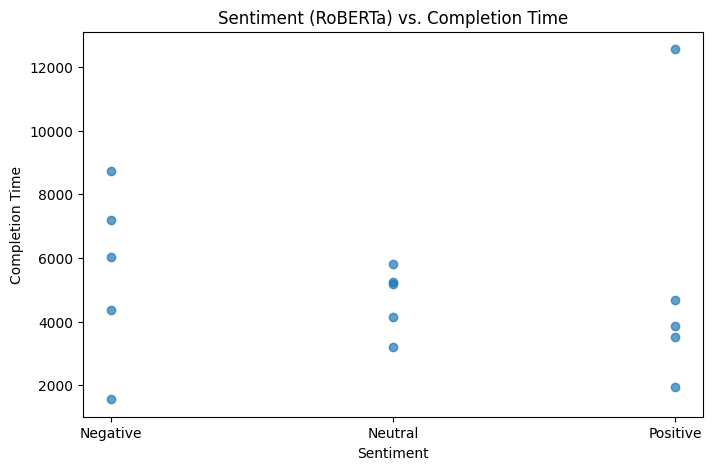

In [5]:
sentiment_distribution = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [40, 138, 110, 14, 68],
    "Neutral": [117, 295, 259, 63, 118],
    "Positive": [29, 80, 56, 2, 34]
})

# Average completion time per sentiment per project (RoBERTa)
completion_time = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [1563.81, 6043.78, 4369.55, 8725.10, 7187.59],
    "Neutral": [3199.08, 4147.66, 5232.46, 5172.73, 5813.80],
    "Positive": [3514.92, 1949.18, 4677.05, 3872.63, 12555.76]  
})

sentiment_distribution_long = sentiment_distribution.melt(id_vars="Project", var_name="Sentiment", value_name="Count")
completion_time_long = completion_time.melt(id_vars="Project", var_name="Sentiment", value_name="Completion Time")

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = sentiment_distribution_long[sentiment_distribution_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Count"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Count")
plt.title("Sentiment Distribution per Project (RoBERTa)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = completion_time_long[completion_time_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Completion Time"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Completion Time")
plt.title("Average Completion Time by Sentiment (RoBERTa)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
completion_time_long.boxplot(by="Sentiment", column="Completion Time", grid=False)
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Completion Time Distribution by Sentiment (RoBERTa)")
plt.suptitle("")
plt.show()


plt.figure(figsize=(8, 5))
sentiment_mapping = {"Negative": 1, "Neutral": 2, "Positive": 3}
completion_time_long["Sentiment Numeric"] = completion_time_long["Sentiment"].map(sentiment_mapping)
plt.scatter(completion_time_long["Sentiment Numeric"], completion_time_long["Completion Time"], alpha=0.7)
plt.xticks([1, 2, 3], ["Negative", "Neutral", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Sentiment (RoBERTa) vs. Completion Time")
plt.show()


In [6]:
positive_durations = data[data["roberta"] == "positive"]["duration"]
neutral_durations = data[data["roberta"] == "neutral"]["duration"]
negative_durations = data[data["roberta"] == "negative"]["duration"]

# Kruskal-Wallis
h_stat, p_value = kruskal(positive_durations, neutral_durations, negative_durations)

print("\n=== Kruskal-Wallis H Test ===")
print(f"Test Statistic: {h_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Significant difference found between sentiment groups. Proceeding with pairwise tests.\n")
else:
    print("No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.")
    exit() 

# Pairwise Mann-Whitney U Tests
print("\n=== Pairwise Mann-Whitney U Tests ===")
comparisons = [("negative", "positive"), ("negative", "neutral")]
for group1, group2 in comparisons:
    group1_durations = data[data["roberta"] == group1]["duration"]
    group2_durations = data[data["roberta"] == group2]["duration"]
    
    u_stat, p_value = mannwhitneyu(group1_durations, group2_durations, alternative='greater')
    
    print(f"Comparing {group1} vs {group2}:")
    print(f"  - Mann-Whitney U Statistic: {u_stat}")
    print(f"  - P-value: {p_value}")

    if p_value < 0.05:
        print(f"  - **Reject H₀**: {group1} sentiment issues take significantly longer to resolve than {group2} issues.\n")
    else:
        print(f"  - **Fail to reject H₀**: No significant difference between {group1} and {group2} in resolution time.\n")



=== Kruskal-Wallis H Test ===
Test Statistic: 5.087716378303762, P-value: 0.07856270453614723
No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.

=== Pairwise Mann-Whitney U Tests ===
Comparing negative vs positive:
  - Mann-Whitney U Statistic: 41222.5
  - P-value: 0.01601056277479339
  - **Reject H₀**: negative sentiment issues take significantly longer to resolve than positive issues.

Comparing negative vs neutral:
  - Mann-Whitney U Statistic: 162819.0
  - P-value: 0.17953459948394213
  - **Fail to reject H₀**: No significant difference between negative and neutral in resolution time.


## BERT

project
camel     186
hadoop    513
hbase     425
impala     79
thrift    220
dtype: int64
bert     negative  neutral  positive
project                             
camel          41      114        31
hadoop        132      302        79
hbase         102      272        51
impala         13       61         5
thrift         52      133        35
project  bert    
camel    negative     1732.213780
         neutral      3072.921762
         positive     3788.495054
hadoop   negative     5834.046141
         neutral      4432.884629
         positive     1325.459940
hbase    negative     4379.944946
         neutral      5680.445056
         positive     2077.209619
impala   negative     6932.174188
         neutral      5773.886393
         positive     2690.667056
thrift   negative     7411.717516
         neutral      6084.141589
         positive    11631.100183
Name: duration, dtype: float64


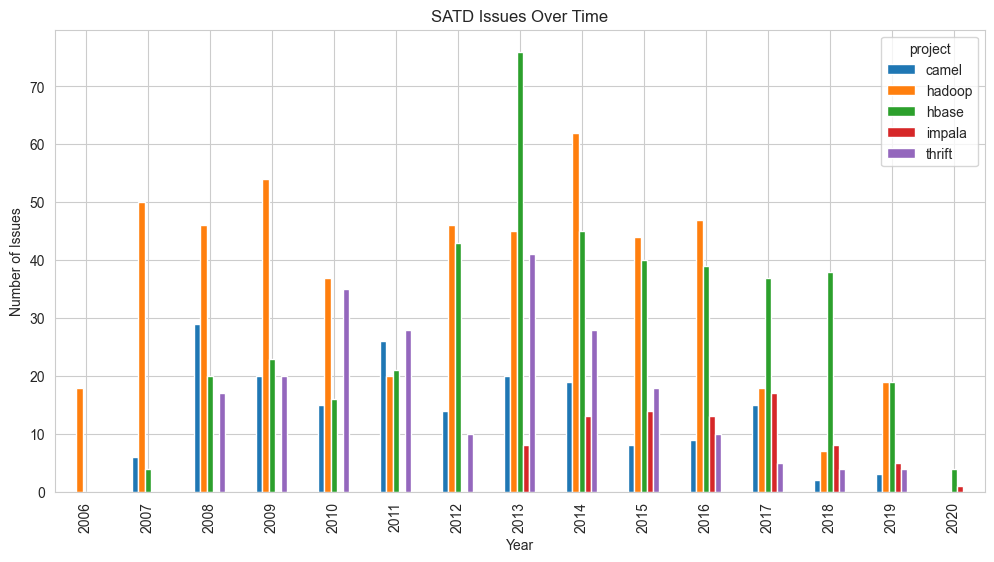

In [3]:
# Count SATD issues by project
satd_counts = data.groupby('project').size()
print(satd_counts)

# Sentiment distribution by project
sentiment_by_project = data.groupby(['project', 'bert']).size().unstack(fill_value=0)
print(sentiment_by_project)

# Average duration by project and sentiment
avg_duration = data.groupby(['project', 'bert'])['duration'].mean()
print(avg_duration)

data['created_year'] = data['created'].dt.year
issues_over_time = data.groupby(['project', 'created_year']).size().unstack(fill_value=0)

issues_over_time.T.plot(kind='bar', figsize=(12, 6), title="SATD Issues Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.show()


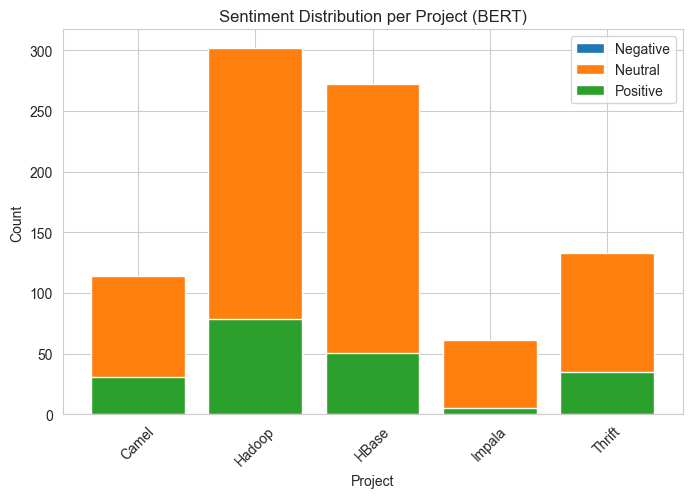

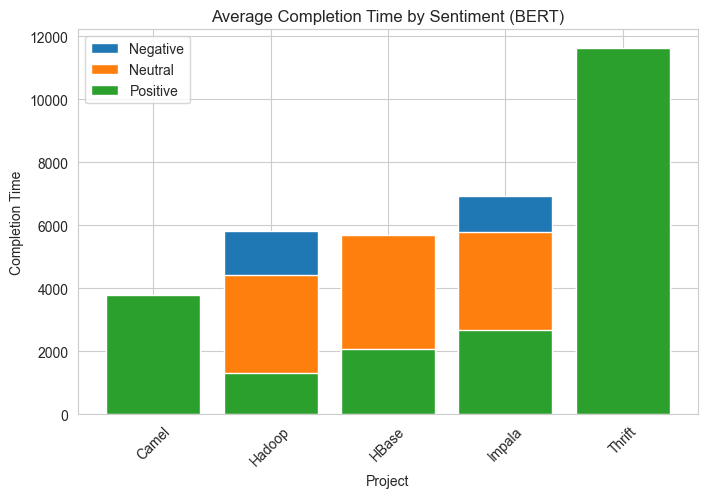

<Figure size 800x500 with 0 Axes>

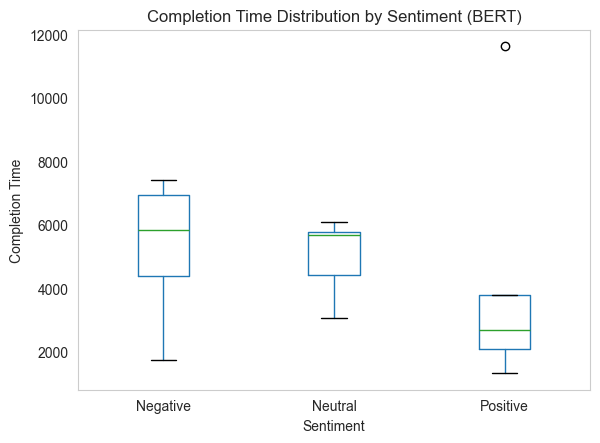

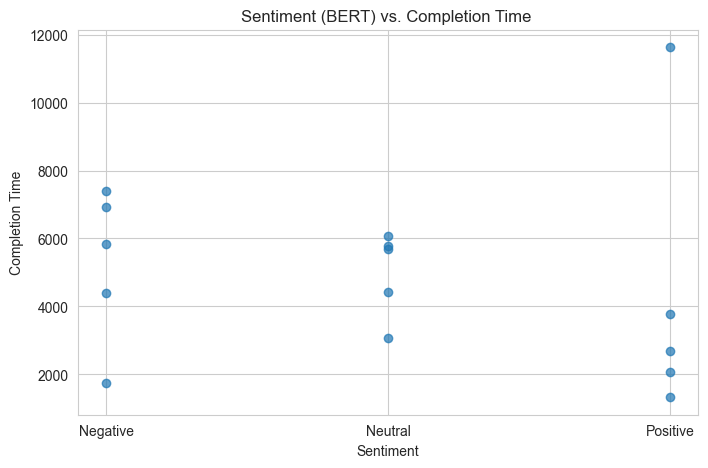

In [4]:
sentiment_distribution = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [41, 132, 102, 13, 52],
    "Neutral": [114, 302, 272, 61, 133],
    "Positive": [31, 79, 51, 5, 35]
})

# Average completion time per sentiment per project (BERT)
completion_time = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [1732.21, 5834.05, 4379.94, 6932.17, 7411.72],
    "Neutral": [3072.92, 4432.88, 5680.45, 5773.88, 6084.14],
    "Positive": [3788.49, 1325.46, 2077.21, 2690.67, 11631.1]  
})

sentiment_distribution_long = sentiment_distribution.melt(id_vars="Project", var_name="Sentiment", value_name="Count")
completion_time_long = completion_time.melt(id_vars="Project", var_name="Sentiment", value_name="Completion Time")

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = sentiment_distribution_long[sentiment_distribution_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Count"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Count")
plt.title("Sentiment Distribution per Project (BERT)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = completion_time_long[completion_time_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Completion Time"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Completion Time")
plt.title("Average Completion Time by Sentiment (BERT)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
completion_time_long.boxplot(by="Sentiment", column="Completion Time", grid=False)
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Completion Time Distribution by Sentiment (BERT)")
plt.suptitle("")
plt.show()


plt.figure(figsize=(8, 5))
sentiment_mapping = {"Negative": 1, "Neutral": 2, "Positive": 3}
completion_time_long["Sentiment Numeric"] = completion_time_long["Sentiment"].map(sentiment_mapping)
plt.scatter(completion_time_long["Sentiment Numeric"], completion_time_long["Completion Time"], alpha=0.7)
plt.xticks([1, 2, 3], ["Negative", "Neutral", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Sentiment (BERT) vs. Completion Time ")
plt.show()


In [5]:
positive_durations = data[data["bert"] == "positive"]["duration"]
neutral_durations = data[data["bert"] == "neutral"]["duration"]
negative_durations = data[data["bert"] == "negative"]["duration"]

# Kruskal-Wallis
h_stat, p_value = kruskal(positive_durations, neutral_durations, negative_durations)

print("\n=== Kruskal-Wallis H Test ===")
print(f"Test Statistic: {h_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Significant difference found between sentiment groups. Proceeding with pairwise tests.\n")
else:
    print("No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.")
    exit() 

# Pairwise Mann-Whitney U Tests
print("\n=== Pairwise Mann-Whitney U Tests ===")
comparisons = [("negative", "positive"), ("negative", "neutral")]
for group1, group2 in comparisons:
    group1_durations = data[data["bert"] == group1]["duration"]
    group2_durations = data[data["bert"] == group2]["duration"]
    
    u_stat, p_value = mannwhitneyu(group1_durations, group2_durations, alternative='greater')
    
    print(f"Comparing {group1} vs {group2}:")
    print(f"  - Mann-Whitney U Statistic: {u_stat}")
    print(f"  - P-value: {p_value}")

    if p_value < 0.05:
        print(f"  - **Reject H₀**: {group1} sentiment issues take significantly longer to resolve than {group2} issues.\n")
    else:
        print(f"  - **Fail to reject H₀**: No significant difference between {group1} and {group2} in resolution time.\n")



=== Kruskal-Wallis H Test ===
Test Statistic: 3.8661050824851415, P-value: 0.1447058031799428
No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.

=== Pairwise Mann-Whitney U Tests ===
Comparing negative vs positive:
  - Mann-Whitney U Statistic: 36973.5
  - P-value: 0.05530769602645747
  - **Fail to reject H₀**: No significant difference between negative and positive in resolution time.

Comparing negative vs neutral:
  - Mann-Whitney U Statistic: 149440.0
  - P-value: 0.5360683042212223
  - **Fail to reject H₀**: No significant difference between negative and neutral in resolution time.


## Temporal Trends

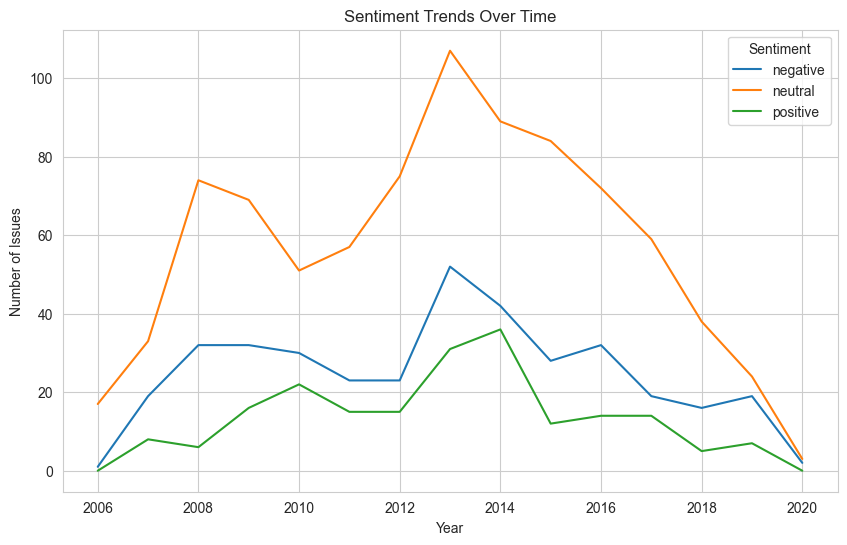

In [4]:
# Sentiment trends
sentiment_trends = data.groupby(['created_year', 'roberta']).size().unstack(fill_value=0)

sentiment_trends.plot(kind='line', figsize=(10, 6), title="Sentiment Trends Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Sentiment")
plt.show()


## Statistical Tests

In [5]:
# Spearman correlation between duration and sentiment
data['roberta_numeric'] = data['roberta'].map({'positive': 1, 'neutral': 0, 'negative': -1})
correlation, p_value = spearmanr(data['duration'], data['roberta_numeric'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")


Spearman Correlation: -0.05494821667462616, P-value: 0.038215304262765724


In [6]:
# Contingency table: sentiment vs project
contingency_table = pd.crosstab(data['project'], data['roberta'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, P-value: {p}")


Chi-square statistic: 22.346698748091626, P-value: 0.004312517310147429


In [7]:
# Cohen's kappa for agreement
agreement = cohen_kappa_score(data['roberta'], data['bert'])
print(f"Cohen's Kappa: {agreement}")


Cohen's Kappa: 0.7198373648922027


## Separating data based on models

In [8]:
# Agreement analysis: RoBERTa vs BERT
from sklearn.metrics import confusion_matrix, cohen_kappa_score

conf_matrix = pd.crosstab(data['roberta'], data['bert'])
print("Confusion Matrix:")
print(conf_matrix)

kappa = cohen_kappa_score(data['roberta'], data['bert'])
print(f"Cohen's Kappa: {kappa}")


Confusion Matrix:
bert      negative  neutral  positive
roberta                              
negative       285       85         0
neutral         53      759        40
positive         2       38       161
Cohen's Kappa: 0.7198373648922027


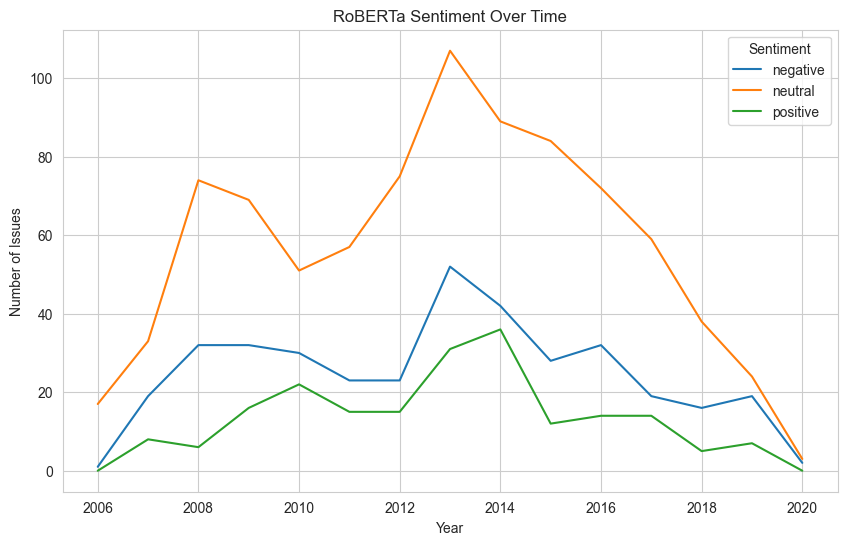

In [9]:
# RoBERTa
roberta_trends = data.groupby(['created_year', 'roberta']).size().unstack(fill_value=0)
roberta_trends.plot(kind='line', figsize=(10, 6), title="RoBERTa Sentiment Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Sentiment")
plt.show()


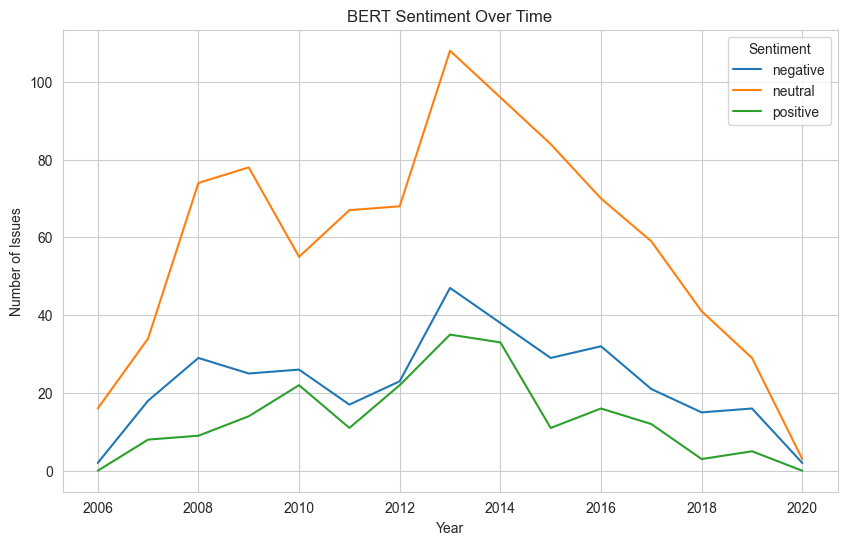

In [10]:
# BERT
bert_trends = data.groupby(['created_year', 'bert']).size().unstack(fill_value=0)
bert_trends.plot(kind='line', figsize=(10, 6), title="BERT Sentiment Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Sentiment")
plt.show()


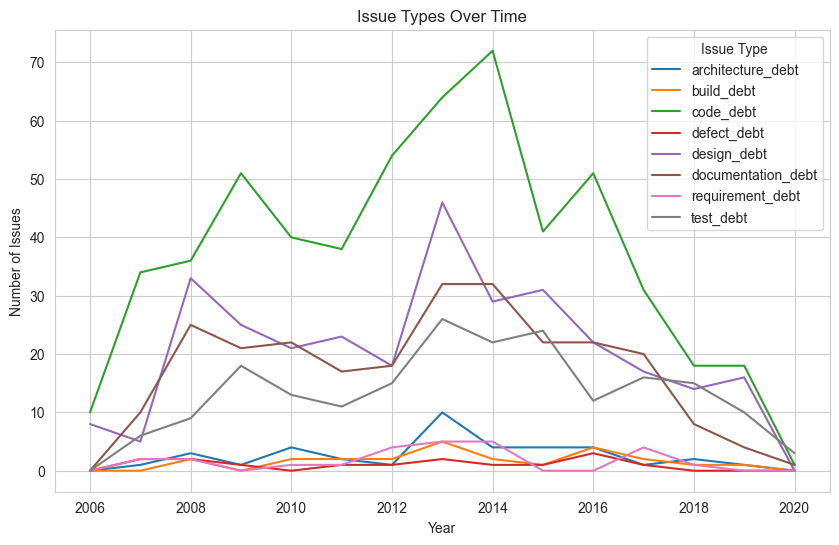

In [11]:
issue_type_trends = data.groupby(['created_year', 'classification']).size().unstack(fill_value=0)
issue_type_trends.plot(kind='line', figsize=(10, 6), title="Issue Types Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Issue Type")
plt.show()


In [12]:
disagreements = data[data['roberta'] != data['bert']]

#disagreement
disagreement_by_project = disagreements.groupby('project').size()
disagreement_by_issue_type = disagreements.groupby('classification').size()


print("Disagreements by Project:")
print(disagreement_by_project)
print("\nDisagreements by Issue Type:")
print(disagreement_by_issue_type)


Disagreements by Project:
project
camel     25
hadoop    74
hbase     64
impala    10
thrift    45
dtype: int64

Disagreements by Issue Type:
classification
architecture_debt      4
build_debt             7
code_debt             86
defect_debt            1
design_debt           47
documentation_debt    36
requirement_debt       3
test_debt             34
dtype: int64


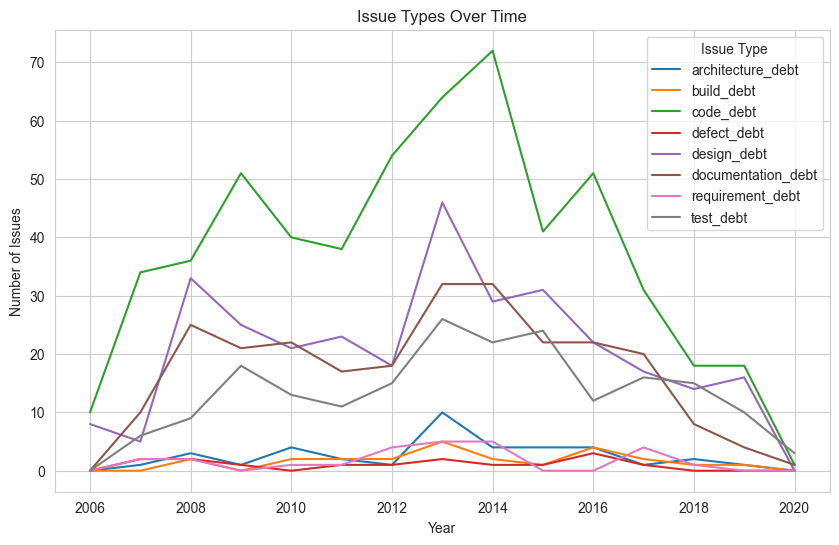

In [13]:
#Volume and Nature SATD by issue type

issue_type_trends = data.groupby(['created_year', 'classification']).size().unstack(fill_value=0)
issue_type_trends.plot(kind='line', figsize=(10, 6), title="Issue Types Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Issue Type")
plt.show()


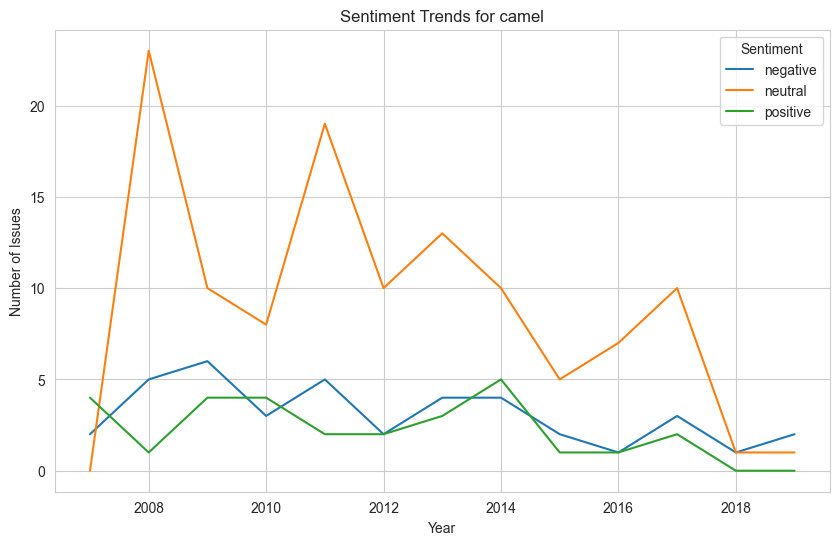

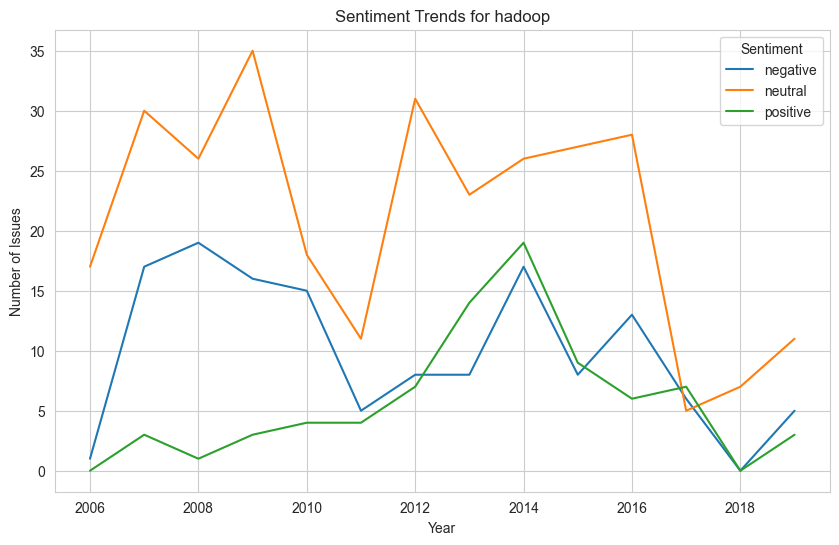

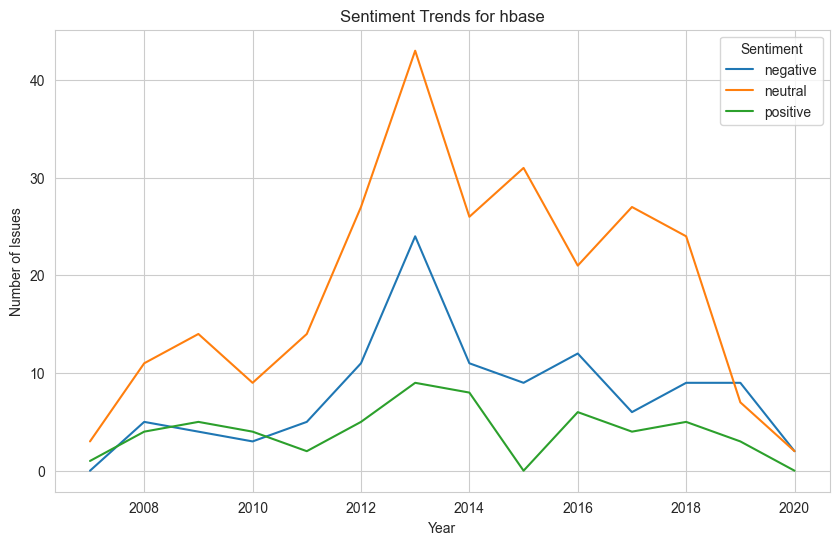

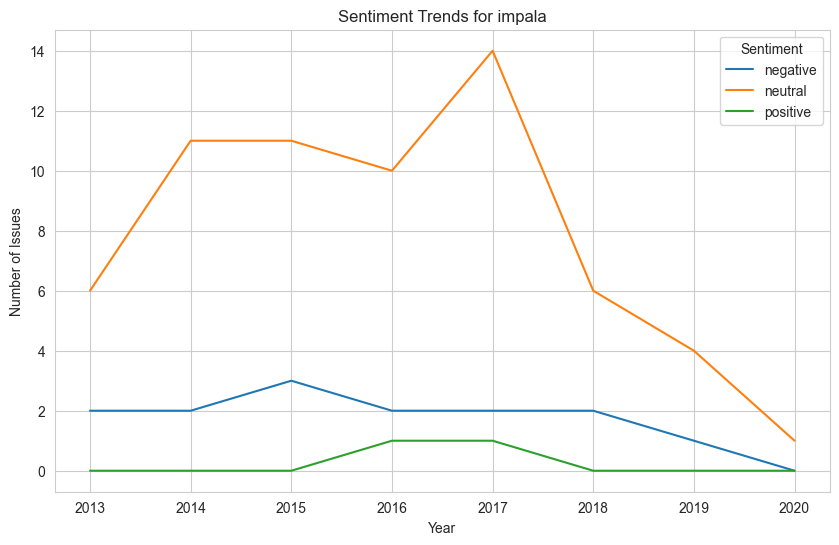

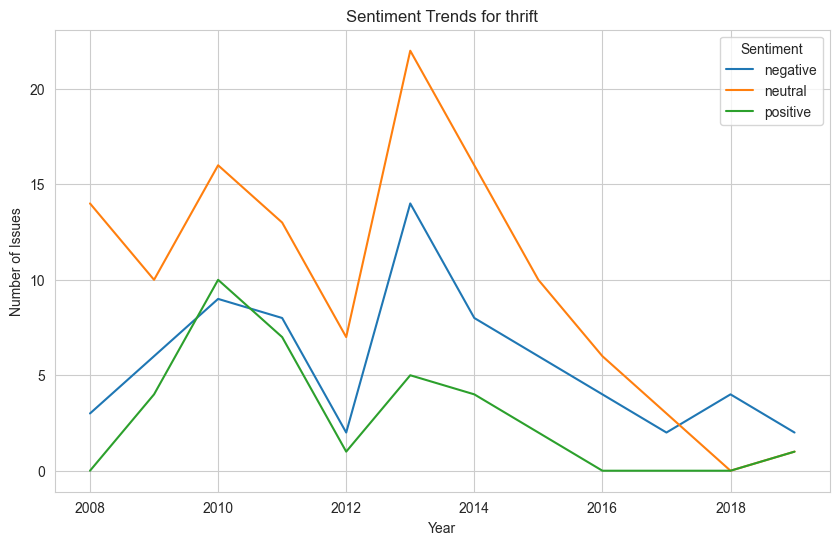

In [14]:
for project in data['project'].unique():
    project_data = data[data['project'] == project]
    sentiment_trends = project_data.groupby(['created_year', 'roberta']).size().unstack(fill_value=0)
    sentiment_trends.plot(kind='line', figsize=(10, 6), title=f"Sentiment Trends for {project}")
    plt.ylabel("Number of Issues")
    plt.xlabel("Year")
    plt.legend(title="Sentiment")
    plt.show()


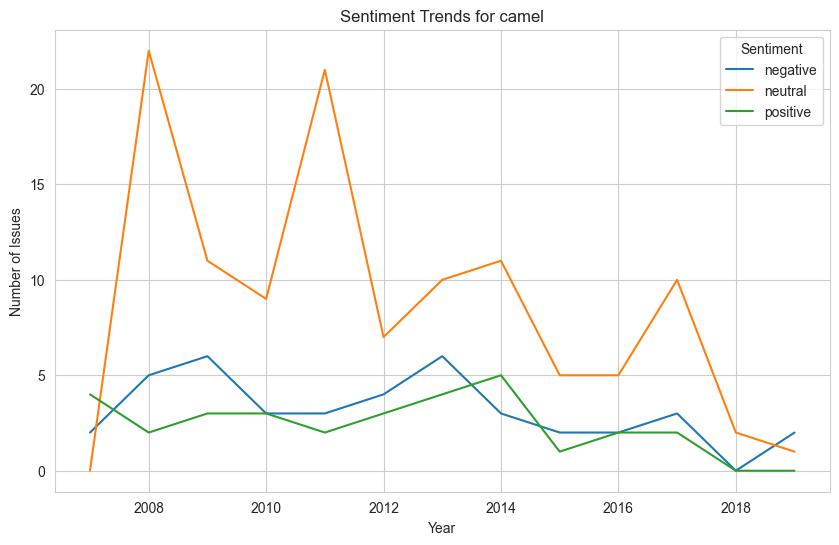

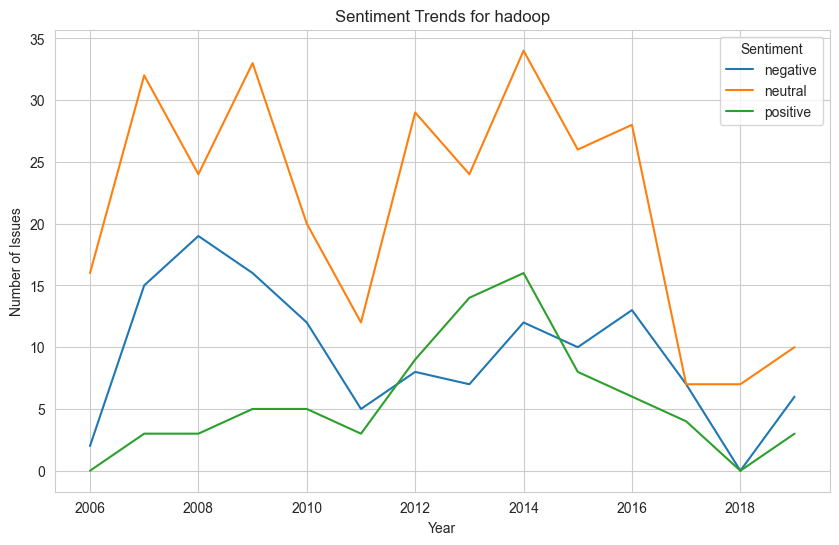

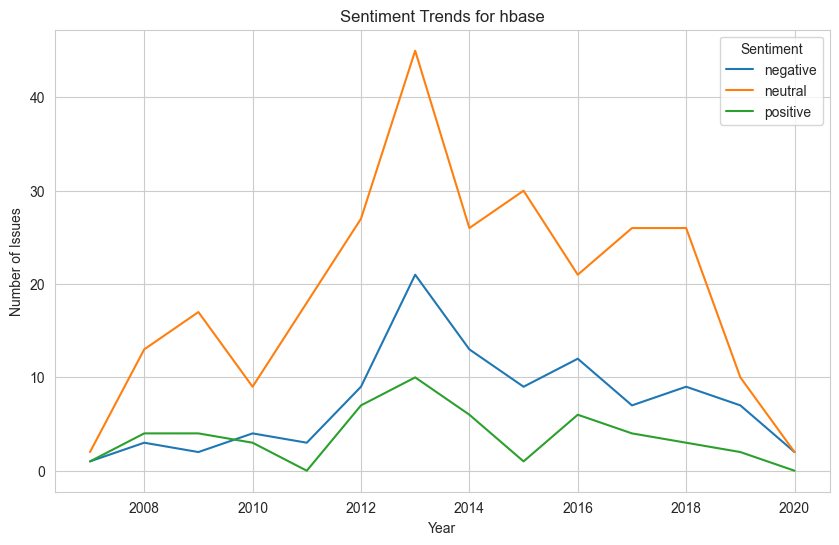

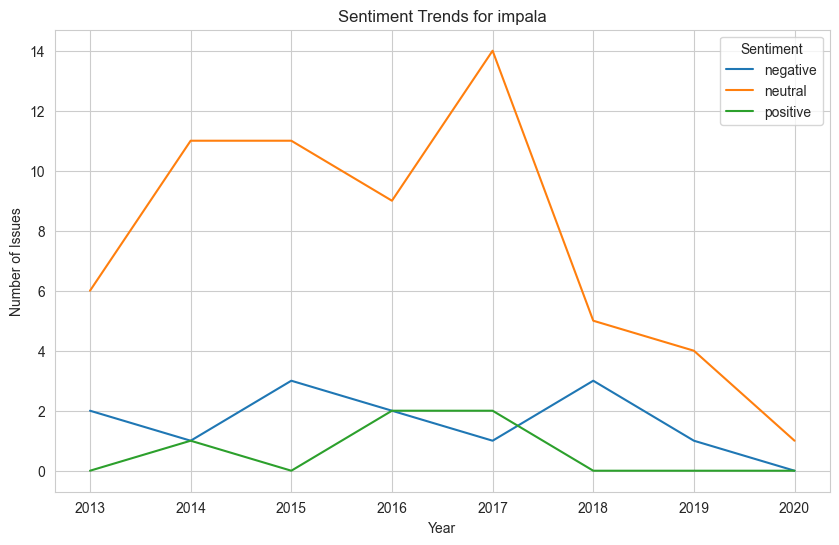

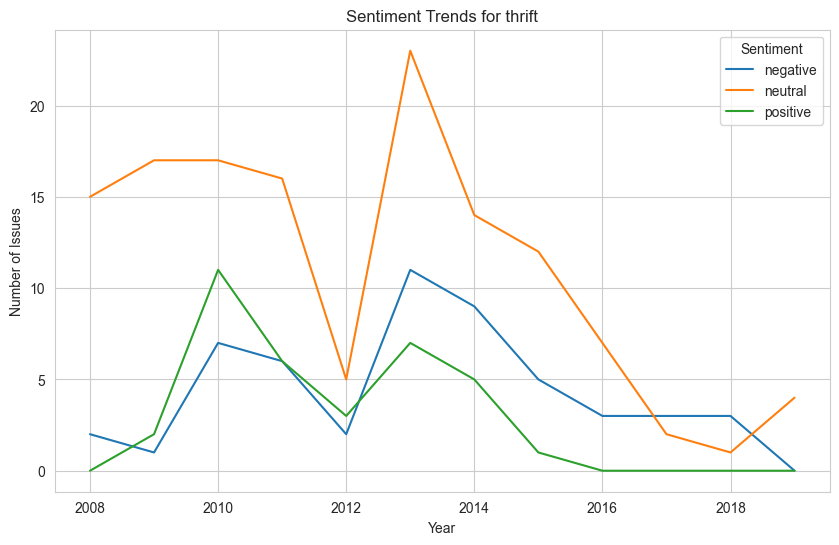

In [15]:
for project in data['project'].unique():
    project_data = data[data['project'] == project]
    sentiment_trends = project_data.groupby(['created_year', 'bert']).size().unstack(fill_value=0)
    sentiment_trends.plot(kind='line', figsize=(10, 6), title=f"Sentiment Trends for {project}")
    plt.ylabel("Number of Issues")
    plt.xlabel("Year")
    plt.legend(title="Sentiment")
    plt.show()


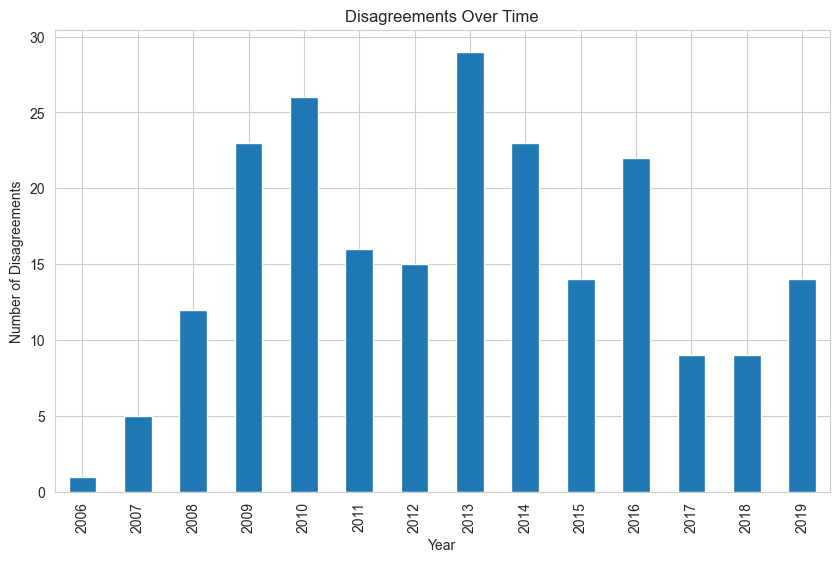

In [16]:
disagreements = data[data['roberta'] != data['bert']]
disagreement_by_year = disagreements.groupby('created_year').size()
disagreement_by_year.plot(kind='bar', figsize=(10, 6), title="Disagreements Over Time")
plt.ylabel("Number of Disagreements")
plt.xlabel("Year")
plt.show()


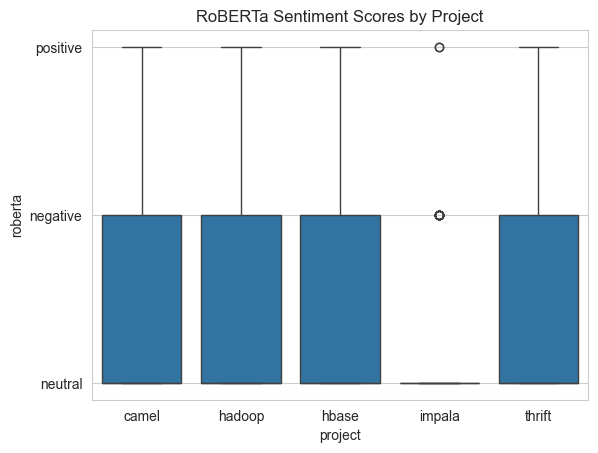

In [17]:
sns.boxplot(x='project', y='roberta', data=data)
plt.title("RoBERTa Sentiment Scores by Project")
plt.show()

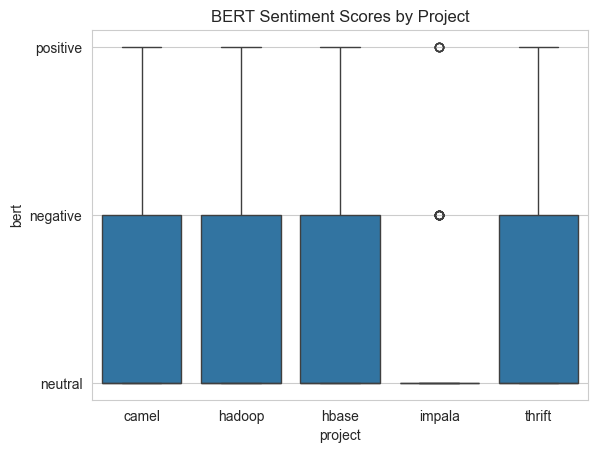

In [18]:
sns.boxplot(x='project', y='bert', data=data)
plt.title("BERT Sentiment Scores by Project")
plt.show()

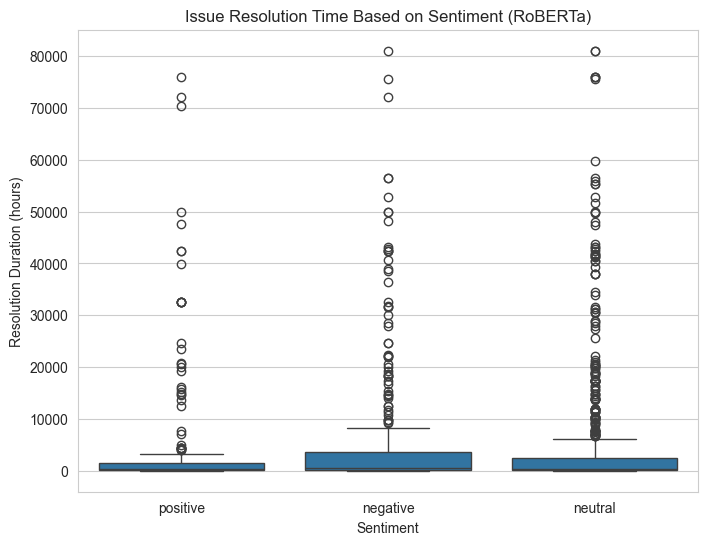

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot of duration by sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x=data["roberta"], y=data["duration"])
plt.title("Issue Resolution Time Based on Sentiment (RoBERTa)")
plt.xlabel("Sentiment")
plt.ylabel("Resolution Duration (hours)")
plt.show()


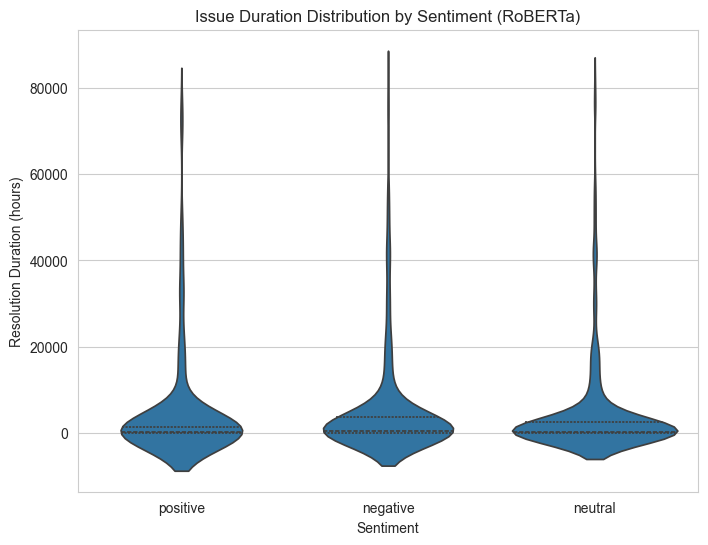

In [20]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=data["roberta"], y=data["duration"], inner="quartile")
plt.title("Issue Duration Distribution by Sentiment (RoBERTa)")
plt.xlabel("Sentiment")
plt.ylabel("Resolution Duration (hours)")
plt.show()


In [28]:
from scipy.stats import shapiro

# Normality test for duration in positive and negative sentiment groups
shapiro_test_pos = shapiro(data[data["roberta"] == "positive"]["duration"])
shapiro_test_neg = shapiro(data[data["roberta"] == "negative"]["duration"])
shapiro_test_neu = shapiro(data[data["roberta"] == "neutral"]["duration"])
print(f"Shapiro Test Positive Sentiment: p-value={shapiro_test_pos.pvalue}")
print(f"Shapiro Test Neutral Sentiment: p-value={shapiro_test_pos.pvalue}")
print(f"Shapiro Test Negative Sentiment: p-value={shapiro_test_neg.pvalue}")


Shapiro Test Positive Sentiment: p-value=7.135129368966606e-25
Shapiro Test Neutral Sentiment: p-value=7.135129368966606e-25
Shapiro Test Negative Sentiment: p-value=4.20377894934461e-31


In [32]:
from scipy.stats import mannwhitneyu

# Get duration values for each sentiment
positive_durations = data[data["roberta"] == "positive"]["duration"]
negative_durations = data[data["roberta"] == "negative"]["duration"]

# Perform Mann-Whitney U test (one-tailed test: negative > positive)
u_stat, p_value = mannwhitneyu(negative_durations, positive_durations, alternative='greater')

print(f"Mann-Whitney U Test Statistic: {u_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Negative sentiment issues take significantly longer to resolve.")
else:
    print("Fail to reject the null hypothesis: No significant difference in resolution time.")


Mann-Whitney U Test Statistic: 41222.5, P-value: 0.01601056277479339
Reject the null hypothesis: Negative sentiment issues take significantly longer to resolve.


In [33]:
from scipy.stats import kruskal

# Get duration values for each sentiment group
positive_durations = data[data["roberta"] == "positive"]["duration"]
neutral_durations = data[data["roberta"] == "neutral"]["duration"]
negative_durations = data[data["roberta"] == "negative"]["duration"]

# Perform Kruskal-Wallis H test
h_stat, p_value = kruskal(positive_durations, neutral_durations, negative_durations)

print(f"Kruskal-Wallis H Test Statistic: {h_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in resolution time among the sentiment groups.")
else:
    print("Fail to reject the null hypothesis: No significant difference in resolution time among the sentiment groups.")


Kruskal-Wallis H Test Statistic: 5.087716378303762, P-value: 0.07856270453614723
Fail to reject the null hypothesis: No significant difference in resolution time among the sentiment groups.


In [34]:
from scipy.stats import mannwhitneyu

# Pairwise Mann-Whitney U tests
pairs = [("negative", "neutral"), ("negative", "positive"), ("neutral", "positive")]
for group1, group2 in pairs:
    group1_durations = data[data["roberta"] == group1]["duration"]
    group2_durations = data[data["roberta"] == group2]["duration"]
    
    u_stat, p_value = mannwhitneyu(group1_durations, group2_durations, alternative='greater')
    
    print(f"Mann-Whitney U Test ({group1} vs {group2}): U-Statistic = {u_stat}, P-value = {p_value}")
    if p_value < 0.05:
        print(f"Reject the null hypothesis: {group1} sentiment issues take significantly longer to resolve than {group2} sentiment issues.\n")
    else:
        print(f"Fail to reject the null hypothesis: No significant difference between {group1} and {group2} resolution times.\n")


Mann-Whitney U Test (negative vs neutral): U-Statistic = 162819.0, P-value = 0.17953459948394213
Fail to reject the null hypothesis: No significant difference between negative and neutral resolution times.

Mann-Whitney U Test (negative vs positive): U-Statistic = 41222.5, P-value = 0.01601056277479339
Reject the null hypothesis: negative sentiment issues take significantly longer to resolve than positive sentiment issues.

Mann-Whitney U Test (neutral vs positive): U-Statistic = 92788.0, P-value = 0.03240731431399092
Reject the null hypothesis: neutral sentiment issues take significantly longer to resolve than positive sentiment issues.


In [35]:
from scipy.stats import kruskal, mannwhitneyu

# Get duration values for each sentiment group
positive_durations = data[data["roberta"] == "positive"]["duration"]
neutral_durations = data[data["roberta"] == "neutral"]["duration"]
negative_durations = data[data["roberta"] == "negative"]["duration"]

# Kruskal-Wallis H test (Overall Test)
h_stat, p_value = kruskal(positive_durations, neutral_durations, negative_durations)

print("\n=== Kruskal-Wallis H Test ===")
print(f"Test Statistic: {h_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Significant difference found between sentiment groups. Proceeding with pairwise tests.\n")
else:
    print("No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.")
    exit()  # Stop further testing if no overall difference is found.

# Pairwise Mann-Whitney U Tests
print("\n=== Pairwise Mann-Whitney U Tests ===")
comparisons = [("negative", "positive"), ("negative", "neutral")]
for group1, group2 in comparisons:
    group1_durations = data[data["roberta"] == group1]["duration"]
    group2_durations = data[data["roberta"] == group2]["duration"]
    
    u_stat, p_value = mannwhitneyu(group1_durations, group2_durations, alternative='greater')
    
    print(f"Comparing {group1} vs {group2}:")
    print(f"  - Mann-Whitney U Statistic: {u_stat}")
    print(f"  - P-value: {p_value}")

    if p_value < 0.05:
        print(f"  - **Reject H₀**: {group1} sentiment issues take significantly longer to resolve than {group2} issues.\n")
    else:
        print(f"  - **Fail to reject H₀**: No significant difference between {group1} and {group2} in resolution time.\n")



=== Kruskal-Wallis H Test ===
Test Statistic: 5.087716378303762, P-value: 0.07856270453614723
No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.

=== Pairwise Mann-Whitney U Tests ===
Comparing negative vs positive:
  - Mann-Whitney U Statistic: 41222.5
  - P-value: 0.01601056277479339
  - **Reject H₀**: negative sentiment issues take significantly longer to resolve than positive issues.

Comparing negative vs neutral:
  - Mann-Whitney U Statistic: 162819.0
  - P-value: 0.17953459948394213
  - **Fail to reject H₀**: No significant difference between negative and neutral in resolution time.


## Combining models

In [14]:
data = pd.read_csv("issue-v2-comments_scored.csv", sep=',')

data['created'] = pd.to_datetime(data['created'], format='%a, %d %b %Y %H:%M:%S %z')
data['resolved'] = pd.to_datetime(data['resolved'], format='%a, %d %b %Y %H:%M:%S %z')

data['duration'] = (data['resolved'] - data['created']).dt.total_seconds() / 3600  # in hours
print(data.head(5))


  project  issue_number issue_type  \
0   camel           201  comment_1   
1   camel           201  comment_2   
2   camel           201  comment_3   
3   camel           201  comment_4   
4   camel           201  comment_0   

                                                text      classification  \
0  Johathan. The patch looks great. Only two issu...  documentation_debt   
1  Hey Claus, Nitpick away :) I fixed up the inde...  documentation_debt   
2  Patch applied. Excellent contribution, thanks ...  documentation_debt   
3  Updated the docs for this at: Unfortunately, i...  documentation_debt   
4  I finally got around to doing this one up. The...           test_debt   

                   indicator                   created  \
0     outdated_documentation 2007-11-02 17:37:12+00:00   
1     outdated_documentation 2007-11-02 17:37:12+00:00   
2     outdated_documentation 2007-11-02 17:37:12+00:00   
3  low_quality_documentation 2007-11-02 17:37:12+00:00   
4              lack_of_t

In [17]:
import pandas as pd

# Function to perform majority voting for each issue
def majority_voting(group):
    all_sentiments = group[["roberta", "bert"]].values.flatten()  # Collect all sentiment labels
    sentiment_counts = pd.Series(all_sentiments).value_counts()  # Count occurrences
    
    # Determine the most common sentiment
    majority_sentiment = sentiment_counts.idxmax()
    
    # Handle ties: If multiple sentiments have the same count, assign "neutral"
    if (sentiment_counts.values == max(sentiment_counts.values)).sum() > 1:
        majority_sentiment = "neutral"

    # Take a single duration value per issue (all are the same)
    issue_duration = group["duration"].iloc[0]

    return pd.Series({"Final Sentiment": majority_sentiment, "Duration": issue_duration})

# Group by project and issue_number to count each issue only once
issue_sentiment = data.groupby(["project", "issue_number"]).apply(majority_voting).reset_index()

# Display the new dataset where each issue appears only once
print(issue_sentiment)


    project  issue_number Final Sentiment     Duration
0     camel           201        positive  4462.752222
1     camel           302         neutral  5617.445833
2     camel           383         neutral   283.488611
3     camel           478         neutral   555.793333
4     camel           612         neutral   174.053333
..      ...           ...             ...          ...
814  thrift          4546         neutral  6374.039444
815  thrift          4616        negative     6.973333
816  thrift          4857         neutral   244.117500
817  thrift          4862         neutral    24.048333
818  thrift          5010         neutral   205.656389

[819 rows x 4 columns]


C:\Users\himaw\AppData\Local\Temp\ipykernel_16544\3313001543.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  issue_sentiment = data.groupby(["project", "issue_number"]).apply(majority_voting).reset_index()


In [24]:
from scipy import stats

shapiro_test = stats.shapiro(issue_sentiment["Duration"])
print(f"Shapiro-Wilk Test p-value: {shapiro_test.pvalue}")

Shapiro-Wilk Test p-value: 1.7488970718148871e-43


In [26]:
levene_test = stats.levene(
    issue_sentiment[issue_sentiment["Final Sentiment"] == "negative"]["Duration"],
    issue_sentiment[issue_sentiment["Final Sentiment"] == "neutral"]["Duration"],
    issue_sentiment[issue_sentiment["Final Sentiment"] == "positive"]["Duration"]
)
print(f"Levene's Test p-value: {levene_test.pvalue}")


Levene's Test p-value: 0.7648703394470088


In [27]:
if shapiro_test.pvalue > 0.05 and levene_test.pvalue > 0.05:
    anova_test = stats.f_oneway(
        issue_sentiment[issue_sentiment["Final Sentiment"] == "negative"]["Duration"],
        issue_sentiment[issue_sentiment["Final Sentiment"] == "neutral"]["Duration"],
        issue_sentiment[issue_sentiment["Final Sentiment"] == "positive"]["Duration"]
    )
    print(f"ANOVA p-value: {anova_test.pvalue}")
else:
    kruskal_test = stats.kruskal(
        issue_sentiment[issue_sentiment["Final Sentiment"] == "negative"]["Duration"],
        issue_sentiment[issue_sentiment["Final Sentiment"] == "neutral"]["Duration"],
        issue_sentiment[issue_sentiment["Final Sentiment"] == "positive"]["Duration"]
    )
    print(f"Kruskal-Wallis Test p-value: {kruskal_test.pvalue}")


Kruskal-Wallis Test p-value: 0.3123131458739474


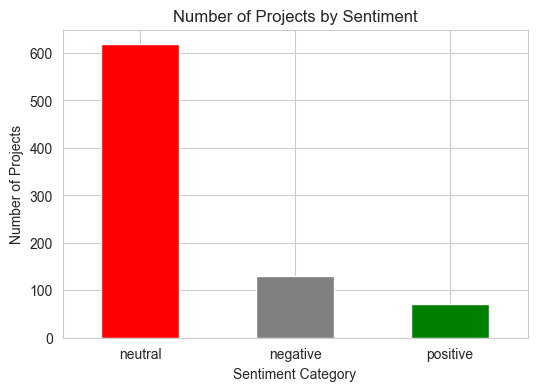

In [29]:
import matplotlib.pyplot as plt

sentiment_counts = issue_sentiment["Final Sentiment"].value_counts()

plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind="bar", color=["red", "gray", "green"])
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Projects")
plt.title("Number of Projects by Sentiment")
plt.xticks(rotation=0)
plt.show()


<Figure size 600x400 with 0 Axes>

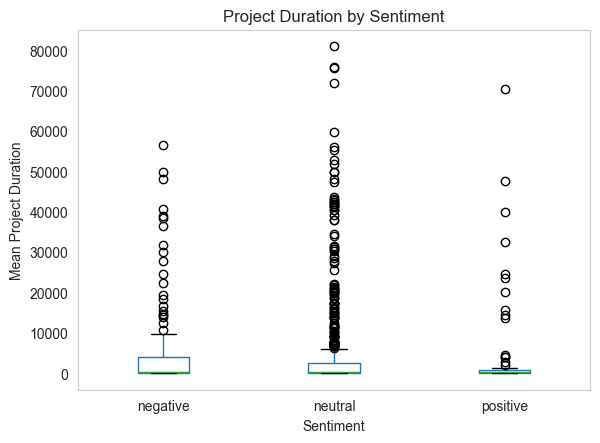

In [32]:
plt.figure(figsize=(6, 4))
issue_sentiment.boxplot(by="Final Sentiment", column="Duration", grid=False)
plt.xlabel("Sentiment")
plt.ylabel("Mean Project Duration")
plt.title("Project Duration by Sentiment")
plt.suptitle("")
plt.show()


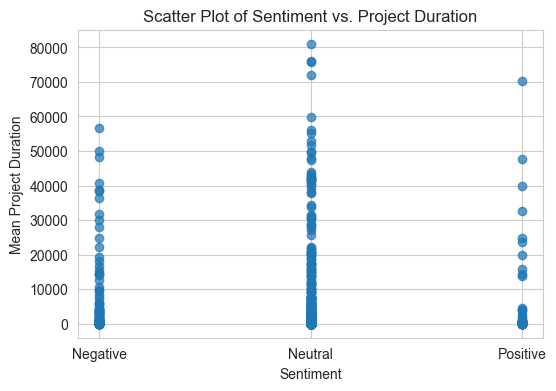

In [34]:
sentiment_mapping = {"negative": 1, "neutral": 2, "positive": 3}
issue_sentiment["Sentiment Numeric"] = issue_sentiment["Final Sentiment"].map(sentiment_mapping)

plt.figure(figsize=(6, 4))
plt.scatter(issue_sentiment["Sentiment Numeric"], issue_sentiment["Duration"], alpha=0.7)
plt.xticks([1, 2, 3], ["Negative", "Neutral", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Mean Project Duration")
plt.title("Scatter Plot of Sentiment vs. Project Duration")
plt.show()


In [19]:
# Function to determine the majority sentiment for a project
def project_majority_voting(group):
    project_sentiments = group["Final Sentiment"].tolist()
    sentiment_counts = pd.Series(project_sentiments).value_counts()  # Count occurrences

    # Determine majority sentiment
    majority_sentiment = sentiment_counts.idxmax()
    
    # Handle ties: Assign "neutral" if there is a tie
    if (sentiment_counts.values == max(sentiment_counts.values)).sum() > 1:
        majority_sentiment = "neutral"

    # Compute mean duration across issues in the project
    mean_duration = group["Duration"].mean()

    return pd.Series({"Project Sentiment": majority_sentiment, "Mean Duration": mean_duration})

# Apply majority voting per project
project_sentiment = issue_sentiment.groupby("project").apply(project_majority_voting).reset_index()

# Display project-level sentiment
print(project_sentiment)


  project Project Sentiment  Mean Duration
0   camel           neutral    3101.451865
1  hadoop           neutral    4532.848781
2   hbase           neutral    5093.081717
3  impala           neutral    4870.358579
4  thrift           neutral    6932.136785


C:\Users\himaw\AppData\Local\Temp\ipykernel_16544\73717426.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  project_sentiment = issue_sentiment.groupby("project").apply(project_majority_voting).reset_index()


In [20]:
from scipy import stats

shapiro_test = stats.shapiro(project_sentiment["Mean Duration"])
print(f"Shapiro-Wilk Test p-value: {shapiro_test.pvalue}")


Shapiro-Wilk Test p-value: 0.7644144762492624


In [23]:
if shapiro_test.pvalue > 0.05:
    anova_test = stats.f_oneway(
        project_sentiment[project_sentiment["Project Sentiment"] == "negative"]["Mean Duration"],
        project_sentiment[project_sentiment["Project Sentiment"] == "neutral"]["Mean Duration"],
        project_sentiment[project_sentiment["Project Sentiment"] == "positive"]["Mean Duration"]
    )
    print(f"ANOVA p-value: {anova_test.pvalue}")
else:
    kruskal_test = stats.kruskal(
        project_sentiment[project_sentiment["Project Sentiment"] == "negative"]["Mean Duration"],
        project_sentiment[project_sentiment["Project Sentiment"] == "neutral"]["Mean Duration"],
        project_sentiment[project_sentiment["Project Sentiment"] == "positive"]["Mean Duration"]
    )
    print(f"Kruskal-Wallis Test p-value: {kruskal_test.pvalue}")


ANOVA p-value: nan


C:\Users\himaw\AppData\Local\Temp\ipykernel_16544\297383859.py:2: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  anova_test = stats.f_oneway(
